# HW3 - Matin Mahmoodkhani - 99522095

Part 1 - ADF Test

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller


In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
import yfinance as yf
import datetime

In [4]:
symbols = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'XRP-USD']
start = "2022-11-01"
end = "2023-11-01"

In [5]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    return result[1] <= 0.1

In [6]:
selected_symbols = []
selected_timeframes = []
for symbol in symbols:
    for timeframe in ['1d', '4h', '1h']:
        tickerData = yf.Ticker(symbol)
        tickerDf = tickerData.history(period=timeframe, start=start, end=end)
        tickerDf = tickerDf[['Close']]
        
        is_stationary = adf_test(tickerDf.Close)
        if(is_stationary == True):
            print(f"{symbol} - {timeframe}: stationary.\n")
            selected_symbols.append(symbol)
            selected_timeframes.append(timeframe)
        else:
            print(f"{symbol} - {timeframe}: not stationary.\n")
        
print("Selected Symbols:", selected_symbols)
print("Selected Timeframes:", selected_timeframes)

ADF Statistic: -0.536060
p-value: 0.884786
BTC-USD - 1d: not stationary.

ADF Statistic: -0.536060
p-value: 0.884786
BTC-USD - 4h: not stationary.

ADF Statistic: -0.536060
p-value: 0.884786
BTC-USD - 1h: not stationary.

ADF Statistic: -1.694665
p-value: 0.433863
ETH-USD - 1d: not stationary.

ADF Statistic: -1.694665
p-value: 0.433863
ETH-USD - 4h: not stationary.

ADF Statistic: -1.694665
p-value: 0.433863
ETH-USD - 1h: not stationary.

ADF Statistic: -3.918862
p-value: 0.001900
USDT-USD - 1d: stationary.

ADF Statistic: -3.918862
p-value: 0.001900
USDT-USD - 4h: stationary.

ADF Statistic: -3.918862
p-value: 0.001900
USDT-USD - 1h: stationary.

ADF Statistic: -1.794289
p-value: 0.383301
BNB-USD - 1d: not stationary.

ADF Statistic: -1.794289
p-value: 0.383301
BNB-USD - 4h: not stationary.

ADF Statistic: -1.794289
p-value: 0.383301
BNB-USD - 1h: not stationary.

ADF Statistic: -1.810963
p-value: 0.375032
XRP-USD - 1d: not stationary.

ADF Statistic: -1.810963
p-value: 0.375032
XRP-

Text(0.5, 0, 'Time')

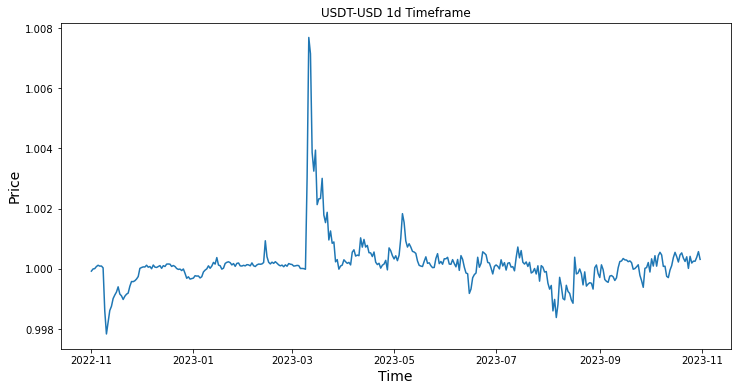

In [7]:
#  USDT-USD is stationary in all its timeframes
#  So, we use 1d timeframe for rest of the project and plot it
tickerData = yf.Ticker("USDT-USD")
currency = tickerData.history(period="1d", start=start, end=end)
currency = currency[['Close']]
plt.figure(figsize=(12, 6))
plt.plot(currency)
plt.title("USDT-USD 1d Timeframe")
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)



Part 2 - ACF & PACF

USDT-USD in timeframe 1D is being used

In [8]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
from datetime import datetime, timedelta, timezone
from time import time

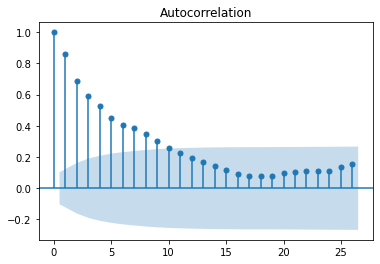

In [9]:
acf_plot = plot_acf(currency.Close)

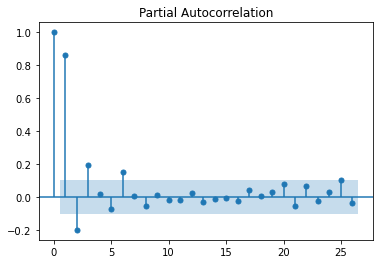

In [10]:
pacf_plot = plot_pacf(currency.Close, method='ywm')

In [11]:
# Based on the results we set p and q
p = 3
q = 7
#  after that, we get train and test data
train_end = datetime(2023, 10, 1, tzinfo=timezone.utc)
test_end = datetime(2023, 11, 1, tzinfo=timezone.utc)

train_data = currency[:train_end]
test_data = currency.loc[train_end + timedelta(days=1):test_end]

AR Model

In [12]:
model = ARIMA(train_data, order=(p,0,0))

C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [13]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time is: ', end-start)

Model fitting time is:  0.24968290328979492


In [14]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  335
Model:                 ARIMA(3, 0, 0)   Log Likelihood                2125.982
Date:                Mon, 11 Dec 2023   AIC                          -4241.964
Time:                        19:47:32   BIC                          -4222.894
Sample:                    11-01-2022   HQIC                         -4234.362
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0002      0.000   4042.597      0.000       1.000       1.001
ar.L1          1.0916      0.023     47.636      0.000       1.047       1.136
ar.L2         -0.4343      0.035    -12.586      0.0

In [15]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [16]:
#get the predictions and residuals 
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data.Close - predictions

C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


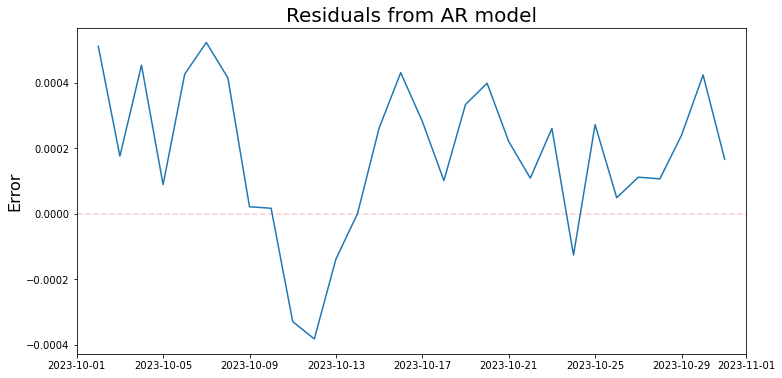

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals from AR model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle ='--', alpha=0.2)
plt.xlim(pd.to_datetime('2023-10-01'), pd.to_datetime('2023-11-01'))
for year in range(pd.to_datetime('2023-10-01').year, pd.to_datetime('2023-11-01').year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-10-01'), color='k', linestyle='--', alpha=0.2)


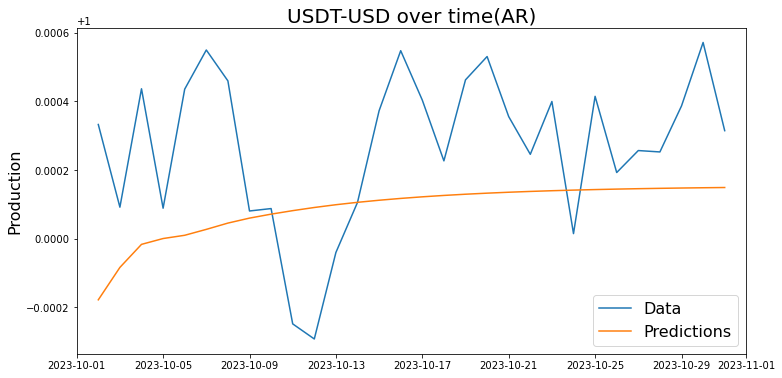

In [18]:
plt.figure(figsize=(12,6))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)
plt.title('USDT-USD over time(AR)', fontsize=20)
plt.xlim(pd.to_datetime('2023-10-01'), pd.to_datetime('2023-11-01'))
plt.ylabel('Production', fontsize=16)
for year in range(2017,2020):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [19]:
non_zero_mask = test_data != 0
print('Mean squared error (MSE):', np.mean(residuals**2))
print('Mean absolute percent error (MAPE):', round(np.mean(abs(residuals / test_data.Close)),4))
# print('Root mean squared error (RMSE):', np.sqrt(np.mean(residuals**2)))


Mean squared error (MSE): 8.422984618968837e-08
Mean absolute percent error (MAPE): 0.0002


MA Model

In [20]:
model = ARIMA(train_data, order=(0,0,q))

C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [21]:
#fit the model
model_fit = model.fit()

In [22]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  335
Model:                 ARIMA(0, 0, 7)   Log Likelihood                2102.878
Date:                Mon, 11 Dec 2023   AIC                          -4187.755
Time:                        19:47:33   BIC                          -4153.428
Sample:                    11-01-2022   HQIC                         -4174.070
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0002      0.000   6160.141      0.000       1.000       1.000
ma.L1          1.0768      0.033     32.835      0.000       1.013       1.141
ma.L2          0.7611      0.048     15.902      0.0

In [23]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [24]:
#get the predictions and residuals 
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data.Close - predictions

C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


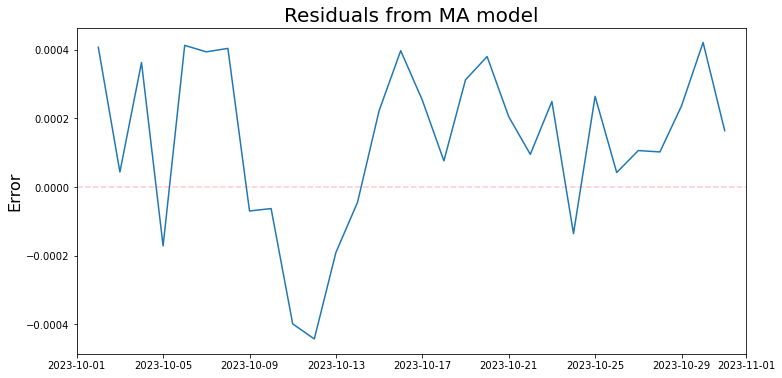

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals from MA model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle ='--', alpha=0.2)
plt.xlim(pd.to_datetime('2023-10-01'), pd.to_datetime('2023-11-01'))
for year in range(pd.to_datetime('2023-10-01').year, pd.to_datetime('2023-11-01').year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-10-01'), color='k', linestyle='--', alpha=0.2)


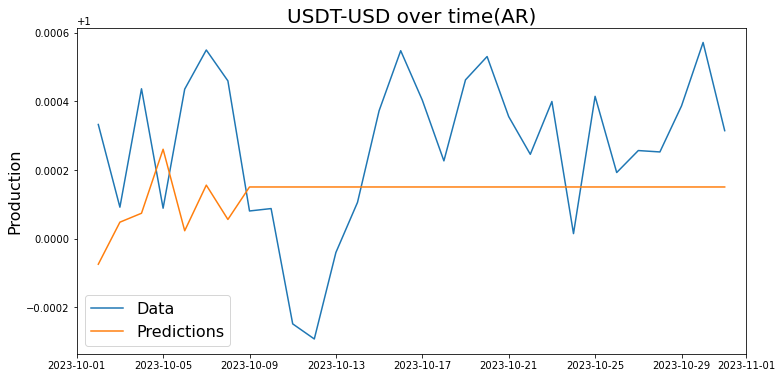

In [26]:
plt.figure(figsize=(12,6))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)
plt.title('USDT-USD over time(AR)', fontsize=20)
plt.xlim(pd.to_datetime('2023-10-01'), pd.to_datetime('2023-11-01'))
plt.ylabel('Production', fontsize=16)
for year in range(2017,2020):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [27]:
non_zero_mask = test_data != 0
print('mean squared error (MSE):', np.mean(residuals**2))
print('Mean absolute percent error (MAPE):', round(np.mean(abs(residuals / test_data.Close)),4))
# print('Root mean squared error (RMSE):', np.sqrt(np.mean(residuals**2)))

mean squared error (MSE): 7.410540575580127e-08
Mean absolute percent error (MAPE): 0.0002


ARMA Model

In [28]:
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [29]:
model = ARIMA(train_data, order=(p,0,q))

In [30]:
model_fit = model.fit()

In [31]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  335
Model:                 ARIMA(3, 0, 7)   Log Likelihood                2131.073
Date:                Mon, 11 Dec 2023   AIC                          -4238.147
Time:                        19:47:34   BIC                          -4192.377
Sample:                    11-01-2022   HQIC                         -4219.900
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0002      0.000   4300.149      0.000       1.000       1.001
ar.L1          1.2401      0.011    114.524      0.000       1.219       1.261
ar.L2         -0.6655      0.010    -64.530      0.0

In [32]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [33]:
#get the predictions and residuals 
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data.Close - predictions

C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


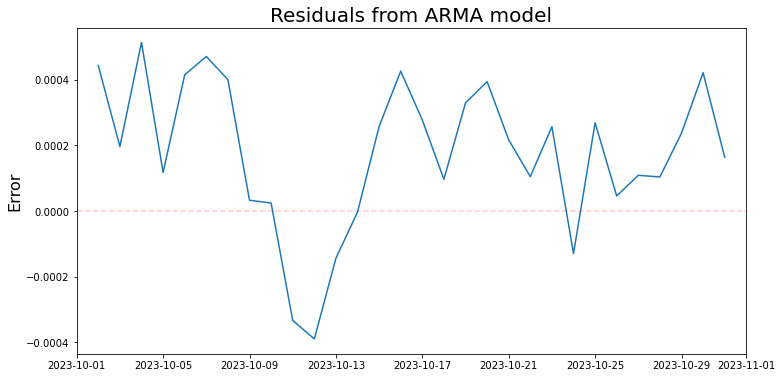

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals from ARMA model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle ='--', alpha=0.2)
plt.xlim(pd.to_datetime('2023-10-01'), pd.to_datetime('2023-11-01'))
for year in range(pd.to_datetime('2023-10-01').year, pd.to_datetime('2023-11-01').year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-10-01'), color='k', linestyle='--', alpha=0.2)


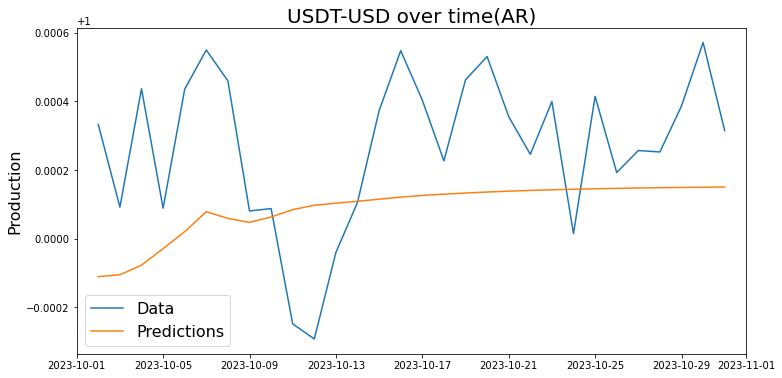

In [35]:
plt.figure(figsize=(12,6))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)
plt.title('USDT-USD over time(AR)', fontsize=20)
plt.xlim(pd.to_datetime('2023-10-01'), pd.to_datetime('2023-11-01'))
plt.ylabel('Production', fontsize=16)
for year in range(2017,2020):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [36]:
non_zero_mask = test_data != 0
print('mean squared error (MSE):', np.mean(residuals**2))
print('Mean absolute percent error (MAPE):', round(np.mean(abs(residuals / test_data.Close)),4))
# print('Root mean squared error (RMSE):', np.sqrt(np.mean(residuals**2)))

mean squared error (MSE): 8.177005666000531e-08
Mean absolute percent error (MAPE): 0.0002


Part 3 - Finding p, q

Finding Best p for AR, MA, ARMA model

(5, 0, 0) MSE:  7.865504916351353e-08 MAPE:  0.00023627964943578642
(10, 0, 0) MSE:  8.39477672760031e-08 MAPE:  0.0002475626460292453
(15, 0, 0) MSE:  8.28698430848129e-08 MAPE:  0.0002452569082349092
(20, 0, 0) MSE:  8.825874381990541e-08 MAPE:  0.0002578971256785526
(25, 0, 0) MSE:  9.752373347975634e-08 MAPE:  0.0002709646889123424
(30, 0, 0) MSE:  9.214297292865637e-08 MAPE:  0.0002634009273018543
(35, 0, 0) MSE:  8.921792886602715e-08 MAPE:  0.00026121436716131715
(40, 0, 0) MSE:  8.64204029708191e-08 MAPE:  0.0002571538818028039
(45, 0, 0) MSE:  1.0049516763475177e-07 MAPE:  0.0002821880137582099
(50, 0, 0) MSE:  1.1128462428954641e-07 MAPE:  0.0002976647511665181
Finding Finished
Best P : 1
Best MSE: 7.82776074490205e-08
Best MAPE: 0.00023657987938266052


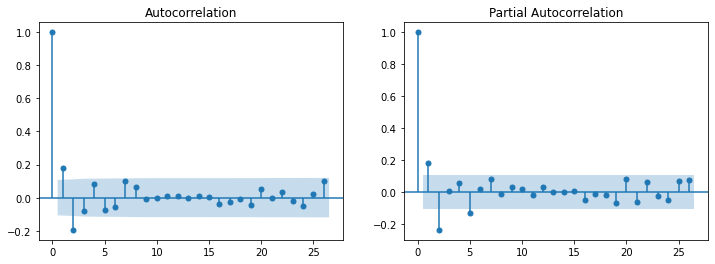

In [38]:
# AR Model
rangeP = range(1, 51)

BestP = None
BestModel = None
MSE = 99999999
MAPE = 99999999

for p in rangeP:
    # Training and Testing the model
    model = ARIMA(train_data, order=(p, 0, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
    residuals = test_data.Close - predictions
    new_mse = np.mean(residuals**2)
    new_mape = np.mean(np.abs(residuals / test_data.Close))
    if(p%5==0):
        print((p,0,0), "MSE: ",new_mse, "MAPE: ",new_mape)
    if new_mse < MSE and new_mape < MAPE:
        BestModel = model_fit
        MSE = new_mse
        MAPE = new_mape
        BestP = p

        
print('Finding Finished')


print(f"Best P : {BestP}")
print(f"Best MSE: {MSE}")
print(f"Best MAPE: {MAPE}")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(BestModel.resid, ax=ax[0])
plot_pacf(BestModel.resid, method='ywm', ax=ax[1])
plt.show()

C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


(0, 0, 5) MSE:  7.272739267658131e-08 MAPE:  0.00022965676459164744
(0, 0, 10) MSE:  6.985705200459479e-08 MAPE:  0.00022753086829253578
(0, 0, 15) MSE:  8.225786630750575e-08 MAPE:  0.00024296878037681735
(0, 0, 20) MSE:  8.251274693359388e-08 MAPE:  0.00024423843309523505
(0, 0, 25) MSE:  7.806496040414035e-08 MAPE:  0.00023764607604857956
(0, 0, 30) MSE:  8.620516820766174e-08 MAPE:  0.00025329481821122874
(0, 0, 35) MSE:  6.228226846123422e-08 MAPE:  0.0002152917158102794
(0, 0, 40) MSE:  6.254192498750077e-08 MAPE:  0.0002157298024914412
(0, 0, 45) MSE:  8.124389140169525e-08 MAPE:  0.0002455070281094059
(0, 0, 50) MSE:  6.266419716208949e-08 MAPE:  0.000215934788413961
Finish
Best Q : 38
Best MSE: 6.225455512577622e-08
Best MAPE: 0.00021524469798581944


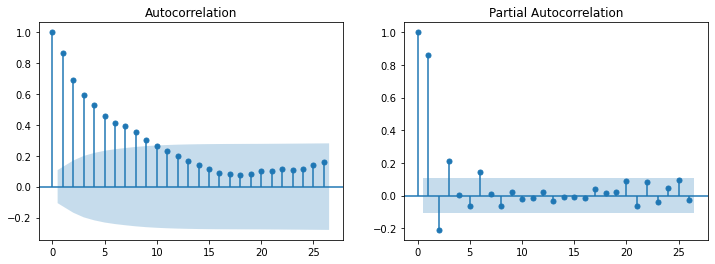

In [39]:
# MA Model
rangeQ = range(1, 51)

BestQ = None
BestModel = None
MSE = 99999999
MAPE = 99999999

for q in rangeQ:
    # Training and Testing the model
    model = ARIMA(train_data, order=(0, 0, q))
    model_fit = model.fit()
    predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
    residuals = test_data.Close - predictions
    new_mse = np.mean(residuals**2)
    new_mape = np.mean(np.abs(residuals / test_data.Close))
    if(q%5==0):
        print((0,0,q), "MSE: ",new_mse, "MAPE: ",new_mape)
    if new_mse < MSE and new_mape < MAPE:
        BestModel = model_fit
        MSE = new_mse
        MAPE = new_mape
        BestQ = q

        
print('Finish')

print(f"Best Q : {BestQ}")
print(f"Best MSE: {MSE}")
print(f"Best MAPE: {MAPE}")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(BestModel.resid, ax=ax[0])
plot_pacf(BestModel.resid, method='ywm', ax=ax[1])
plt.show()

C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Matin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(5, 0, 5) MSE:  8.346670213509574e-08 MAPE:  0.0002473568475179563
(5, 0, 10) MSE:  6.255762884664446e-08 MAPE:  0.00021575637919324532
(5, 0, 15) MSE:  8.263277630491398e-08 MAPE:  0.00024533078415818276
(5, 0, 20) MSE:  8.44735294142831e-08 MAPE:  0.0002500152794427842
(5, 0, 25) MSE:  7.863337162085224e-08 MAPE:  0.0002393587279395569
(10, 0, 5) MSE:  6.255989133979459e-08 MAPE:  0.00021576016975449495
(10, 0, 10) MSE:  6.255537841843618e-08 MAPE:  0.00021575253104234046
(10, 0, 15) MSE:  8.113874416892147e-08 MAPE:  0.00024239273378179189
(10, 0, 20) MSE:  8.413646257118017e-08 MAPE:  0.00024994876720855715
(10, 0, 25) MSE:  7.439751433666153e-08 MAPE:  0.00023395454504777138
(15, 0, 5) MSE:  8.296844506831618e-08 MAPE:  0.00024554213883997415
(15, 0, 10) MSE:  6.255687236195861e-08 MAPE:  0.0002157549833183734
(15, 0, 15) MSE:  8.689204417538927e-08 MAPE:  0.00025405327168176196
(15, 0, 20) MSE:  9.405572601631595e-08 MAPE:  0.0002698531139031951
(15, 0, 25) MSE:  4.78546249114037

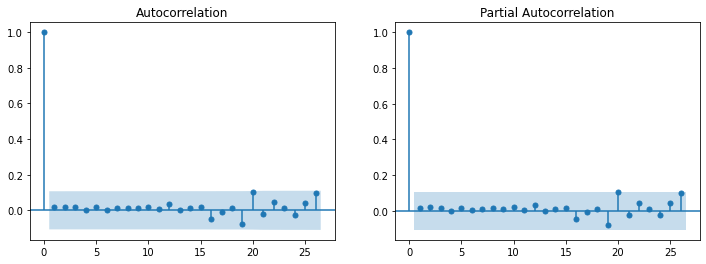

In [40]:
# ARMA Model
rangeP = range(1, 26)
rangeQ = range(1, 26)

BestP = None
BestQ = None
BestModel = None
MSE = 99999999
MAPE = 99999999

for p in rangeP:
    for q in rangeQ:
        # Training and Testing the model
        model = ARIMA(train_data, order=(p, 0, q))
        model_fit = model.fit()
        predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
        residuals = test_data.Close - predictions
        new_mse = np.mean(residuals**2)
        new_mape = np.mean(np.abs(residuals / test_data.Close))
#         print((p,0,q), new_mse)
#         print((p,0,q), new_mape)
#         print()
        if(p%5==0 and q%5==0):
            print((p,0,q), "MSE: ",new_mse, "MAPE: ",new_mape)
        if new_mse < MSE and new_mape < MAPE:
            BestModel = model_fit
            MSE = new_mse
            MAPE = new_mape
            BestP = p
            BestQ = q

        
print('Finish')

print(f"Best P : {BestP}")
print(f"Best Q : {BestQ}")
print(f"Best MSE: {MSE}")
print(f"Best MAPE: {MAPE}")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(BestModel.resid, ax=ax[0])
plot_pacf(BestModel.resid, method='ywm', ax=ax[1])
plt.show()